In [1]:
import numpy as np
import cvxpy as cp

from tqdm import tqdm
from matplotlib import pyplot as plt
from matplotlib.ticker import MaxNLocator

import pickle

import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.utils.data as Data
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

In [2]:
from models.LISTA import LISTA_Net
from models.L20_ISTA import L2O_ISTA
from models.TiLISTA import TiLISTA
from models.ALISTA import ALISTA

from utils.ISTA_FISTA import *
from utils.train import train
from utils.synthetic_data import SyntheticSignals

In [3]:
torch.cuda.is_available()

True

In [5]:
# Dimensions for the signal, its sparsity and its observation

n_ = 200
m_ = 150
p_ = 0.1

# Sensing matrix

A_ = torch.normal(0, torch.sqrt(torch.tensor(1/m_)), size = (m_, n_))
A_ /= torch.linalg.norm(A_, dim = 0)

# Building a training set and a test set 
train_set = SyntheticSignals(
    A = A_,
    n = n_,        
    m = m_,
    p = p_,
    SNR = None,
    size = 4000
    ).set_loader()

test_set = SyntheticSignals(
    A = A_,
    n = n_,        
    m = m_,
    p = p_,
    SNR = None,
    size = 1000
    ).set_loader()

In [37]:
class LDC_ISTA(nn.Module):
    def __init__(self, A, mode, lambd=0.1, p =0.012, p_max = 0.12, T = 5):
        super().__init__()
    
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

        assert mode in ['EXP', 'PNEG', 'SCAD']

        self.mode = mode

        self.A = A.to(self.device)  # Move A to the correct device
        self.A.requires_grad = False

        self.T = T

        self.L = torch.max(torch.real(torch.linalg.eigvals(A.t() @ A))).to(self.device)

        # Initialization of the learnable parameters
        self.theta = nn.Parameter(torch.ones(self.T + 1, 1, 1).to(self.device), requires_grad=True)
        self.mu = nn.Parameter(torch.ones(self.T + 1, 1, 1).to(self.device) / self.L, requires_grad=True)
        self.lambd = nn.Parameter(torch.ones(self.T + 1, 1, 1).to(self.device) * lambd, requires_grad=True)
        
        # Linear layers
        self.W1 = nn.Linear(A.shape[1], A.shape[0], bias=False).to(self.device)
        self.W2 = nn.Linear(A.shape[1], A.shape[1], bias=False).to(self.device)

        self.W1.weight.data = torch.clone(A.t()).to(self.device)
        self.W2.weight.data = torch.clone(A.t() @ A).to(self.device)

        # Support selection mechanism parameters
        self.p = p
        self.p_max = p_max

        # Losses when doing inference (placeholder for NMSE accumulation)
        self.losses = torch.zeros(self.T, device=self.device)
        self.est_powers = torch.zeros(self.T, device=self.device)

        # Mode setting for the layer
        if mode == 'EXP':
            self.ddx = self.ddxEXP
            self.eta = self.etaEXP

        if mode == 'PNEG':
            self.P = - nn.Parameter(torch.ones(self.T + 1, 1, 1).to(self.device), requires_grad=True)
            self.ddx = self.ddxNEG
            self.eta = self.etaNEG

        if mode == 'SCAD':
            self.a = nn.Parameter(torch.ones(self.T + 1, 1, 1).to(self.device) * 2, requires_grad=True)
            self.ddx = self.ddxSCAD
            self.eta = self.etaSCAD

    #_________________________________________________________________
    #______________ METHODS FOR ENABLING DIFFERENT LAYERS_____________
    #_________________________________________________________________
    
    # Derivatives of the nonconvex components
    def ddxEXP(self, x, t):
        return torch.sign(x) * self.theta[t,:,:] * (1 - torch.exp(-self.theta[t,:,:] * torch.abs(x)))

    def ddxNEG(self, x, t):
        return -torch.sign(x) * self.P[t,:,:] * self.theta[t,:,:] * (1 - (1 + self.theta[t,:,:] * torch.abs(x)) ** (self.P[t,:,:] - 1))

    def ddxSCAD(self, x, t):
        abs_x = torch.abs(x)

        mask1 = (abs_x <= 1)
        mask2 = (1 / self.theta[t,:,:] < abs_x) & (abs_x <= self.a[t,:,:] / self.theta[t,:,:])
        mask3 = (abs_x > self.a[t,:,:] / self.theta[t,:,:])

        # Compute the value for each condition
        val1 = torch.zeros_like(x)
        val2 = torch.sign(x) * (2 * self.theta[t,:,:] * (self.theta[t,:,:] * abs_x - 1)) / (self.a[t,:,:] ** 2 - 1)
        val3 = torch.sign(x) * (2 * self.theta[t,:,:] / (self.a[t,:,:] + 1))

        # Apply the masks to compute the final result
        result = torch.where(mask1, val1, torch.where(mask2, val2, val3))

        return result

    # Parametrization for the surrogates
    def etaEXP(self, t):
        return self.theta[t,:,:]

    def etaNEG(self, t):
        return -self.P[t,:,:] * self.theta[t,:,:]

    def etaSCAD(self, t):
        return 2 * self.theta[t,:,:] / (self.a[t,:,:] + 1)
    
    #___________________________________________________________________
    #___________________________________________________________________
        
    def _shrink(self, x, beta, t):
        # Get the absolute values of the elements in x
        abs_x = torch.abs(x)
        
        # Sort the elements of x by magnitude along the last dimension (num_features)
        sorted_abs_x, _ = torch.sort(abs_x, dim=-1, descending=True)

        # Determine the threshold index corresponding to the top p% elements in each sample
        p = torch.min(torch.tensor([self.p * t, self.p_max], device=self.device))
        threshold_idx = int(p * x.shape[-1])
        
        # Get the magnitude threshold for the top p% of elements (per batch)
        if threshold_idx > 0:
            threshold_value = sorted_abs_x[:, threshold_idx - 1:threshold_idx]  # Shape: (batch_size, 1)
        else:
            threshold_value = torch.zeros(x.shape[0], 1, device=x.device)  # Shape: (batch_size, 1)

        # Create a mask to exclude the top p% of elements from shrinkage
        mask = abs_x >= threshold_value
        
        # Apply soft thresholding only to elements outside the top p%
        x_shrink = beta * F.softshrink(x / beta, lambd=1)
        
        # Return the original values for the top p% and the shrinked values for others
        return torch.where(mask, x, x_shrink)

    
    def forward(self, y, S=None):     
        # Move inputs to the correct device
        y = y.to(self.device)
        if S is not None:
            S = S.to(self.device)

        # Initial sparse estimate using the first layer
        x = self._shrink(self.mu[0,:,:] * self.W1(y), self.eta(0) * self.lambd[0,:,:] * self.mu[0,:,:], 0)
        
        # Loop over layers to refine the estimate
        for t in range(1, self.T + 1):
            x = self._shrink(x - self.mu[t, :, :] * (self.W2(x) - self.W1(y)) + self.lambd[t,:,:] * self.mu[t,:,:] * self.ddx(x, t), 
                             self.eta(t) * self.lambd[t,:,:] * self.mu[t,:,:],
                             t)
            
            if S is not None:  # During inference, compute the NMSE at each layer
                with torch.no_grad():
                    mse_loss = F.mse_loss(x.detach(), S.detach(), reduction="sum")
                    signal_power = torch.sum(S.detach() ** 2)

                    self.losses[t - 1] += mse_loss.item()
                    self.est_powers[t - 1] += signal_power.item() + 1e-6

        return x

    # Method to compute NMSE during inference mode
    def compute_nmse_inference(self, test_loader):
        # Reset the losses accumulator
        self.losses = torch.zeros(self.T, device=self.device)
        
        # Iterate over test_loader
        for _, (Y, S) in enumerate(test_loader):
            Y, S = Y.to(self.device), S.to(self.device)
            _ = self.forward(Y, S)  # This will accumulate NMSE values
        
        # Convert accumulated NMSE to dB
        nmse_db = 10 * torch.log10(self.losses / self.est_powers)
        
        # Reset the losses after inference
        self.losses = torch.zeros(self.T, device=self.device)
        self.est_powers = torch.zeros(self.T, device=self.device)

        # Return NMSE in dB for each layer
        return nmse_db

In [39]:
M = 10
LAYERS = 5
BETA_INIT = 0.4
EPOCHS = 50
SNR = None

LISTA_LOSS = torch.zeros((M, LAYERS))
LDC_LISTA_EXP_LOSS = torch.zeros((M, LAYERS))
LDC_LISTA_PNEG_LOSS = torch.zeros((M, LAYERS))
LDC_LISTA_SCAD_LOSS = torch.zeros((M, LAYERS))

ISTA_LOSS = torch.zeros((M, LAYERS))
FISTA_LOSS = torch.zeros((M, LAYERS))

for m in tqdm(range(M)):
    # Dimensions for the signal, its sparsity and its observation

    n_ = 200
    m_ = 150
    p_ = 0.1

    # Sensing matrix

    A_ = torch.normal(0, torch.sqrt(torch.tensor(1/m_)), size = (m_, n_))
    A_ /= torch.linalg.norm(A_, dim = 0)

    # Building a training set and a test set 
    train_set = SyntheticSignals(
        A = A_,
        n = n_,        
        m = m_,
        p = p_,
        SNR = SNR,
        size = 4000
        ).set_loader()

    test_set = SyntheticSignals(
        A = A_,
        n = n_,        
        m = m_,
        p = p_,
        SNR = SNR,
        size = 1000
        ).set_loader()
    
    model1 = LISTA_Net(torch.clone(A_), BETA_INIT, LAYERS)
    train(model1, train_set, test_set, num_epochs = EPOCHS, verbose=False)

    model2 = LDC_ISTA(torch.clone(A_), 'EXP', BETA_INIT, T = LAYERS)
    train(model2, train_set, test_set, num_epochs = EPOCHS, verbose=False)

    model3 = LDC_ISTA(torch.clone(A_), 'PNEG', BETA_INIT, T = LAYERS)
    train(model3, train_set, test_set, num_epochs = EPOCHS, verbose=False)

    model4 = LDC_ISTA(torch.clone(A_), 'SCAD', BETA_INIT, T = LAYERS)
    train(model4, train_set, test_set, num_epochs = EPOCHS, verbose=False)

    LISTA_LOSS[m,:] = model1.compute_nmse_inference(test_set)
    LDC_LISTA_EXP_LOSS[m,:] = model2.compute_nmse_inference(test_set)
    LDC_LISTA_PNEG_LOSS[m,:] = model3.compute_nmse_inference(test_set)
    LDC_LISTA_SCAD_LOSS[m,:] = model4.compute_nmse_inference(test_set)

    ISTA_LOSS[m,:] = ISTA_BATCH(test_set, LAYERS, A_, rho = BETA_INIT)
    FISTA_LOSS[m,:] = FISTA_BATCH(test_set, LAYERS, A_, rho = BETA_INIT)

100%|██████████| 10/10 [08:24<00:00, 50.44s/it]


In [40]:
LISTA_LOSS = LISTA_LOSS.cpu().numpy()
LDC_LISTA_EXP_LOSS = LDC_LISTA_EXP_LOSS.cpu().numpy()
LDC_LISTA_PNEG_LOSS = LDC_LISTA_PNEG_LOSS.cpu().numpy()
LDC_LISTA_SCAD_LOSS = LDC_LISTA_SCAD_LOSS.cpu().numpy()

ISTA_LOSS = ISTA_LOSS.cpu().numpy()
FISTA_LOSS = FISTA_LOSS.cpu().numpy()

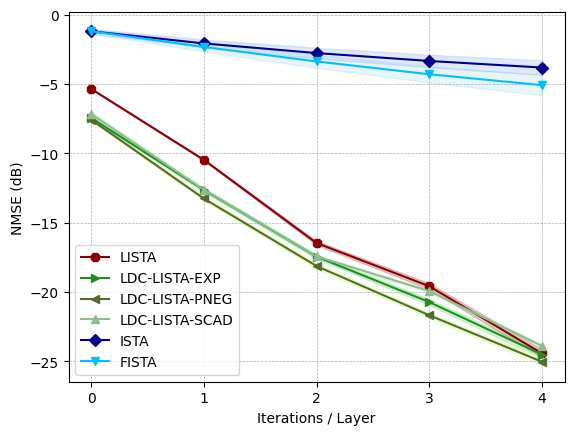

In [43]:
plt.plot(np.mean(LISTA_LOSS, axis = 0), label='LISTA', color='darkred', marker = '8')
plt.fill_between(range(LAYERS), 
                    np.mean(LISTA_LOSS, axis = 0) - (2/np.sqrt(LISTA_LOSS.shape[1])) * np.std(LISTA_LOSS, axis = 0), 
                    np.mean(LISTA_LOSS, axis = 0) + (2/np.sqrt(LISTA_LOSS.shape[1])) * np.std(LISTA_LOSS, axis = 0), 
                    color='darkred', 
                    alpha=0.2)

plt.plot(np.mean(LDC_LISTA_EXP_LOSS, axis = 0), label='LDC-LISTA-EXP', color='forestgreen', marker = '>')
plt.fill_between(range(LAYERS), 
                    np.mean(LDC_LISTA_EXP_LOSS, axis = 0) - (2/np.sqrt(LDC_LISTA_EXP_LOSS.shape[1])) * np.std(LDC_LISTA_EXP_LOSS, axis = 0), 
                    np.mean(LDC_LISTA_EXP_LOSS, axis = 0) + (2/np.sqrt(LDC_LISTA_EXP_LOSS.shape[1])) * np.std(LDC_LISTA_EXP_LOSS, axis = 0), 
                    color='limegreen', 
                    alpha=0.2)

plt.plot(np.mean(LDC_LISTA_PNEG_LOSS, axis = 0), label='LDC-LISTA-PNEG', color='darkolivegreen', marker = '<')
plt.fill_between(range(LAYERS), 
                    np.mean(LDC_LISTA_PNEG_LOSS, axis = 0) - (2/np.sqrt(LDC_LISTA_PNEG_LOSS.shape[1])) * np.std(LDC_LISTA_PNEG_LOSS, axis = 0), 
                    np.mean(LDC_LISTA_PNEG_LOSS, axis = 0) + (2/np.sqrt(LDC_LISTA_PNEG_LOSS.shape[1])) * np.std(LDC_LISTA_PNEG_LOSS, axis = 0), 
                    color='greenyellow', 
                    alpha=0.2)

plt.plot(np.mean(LDC_LISTA_SCAD_LOSS, axis = 0), label='LDC-LISTA-SCAD', color='darkseagreen', marker = '^')
plt.fill_between(range(LAYERS), 
                    np.mean(LDC_LISTA_SCAD_LOSS, axis = 0) - (2/np.sqrt(LDC_LISTA_SCAD_LOSS.shape[1])) * np.std(LDC_LISTA_SCAD_LOSS, axis = 0), 
                    np.mean(LDC_LISTA_SCAD_LOSS, axis = 0) + (2/np.sqrt(LDC_LISTA_SCAD_LOSS.shape[1])) * np.std(LDC_LISTA_SCAD_LOSS, axis = 0), 
                    color='palegreen', 
                    alpha=0.2)

plt.plot(np.mean(ISTA_LOSS, axis = 0), label='ISTA', color='darkblue', marker = 'D')
plt.fill_between(range(LAYERS), 
                np.mean(ISTA_LOSS, axis = 0) - (2/np.sqrt(ISTA_LOSS.shape[1])) * np.std(ISTA_LOSS, axis = 0), 
                np.mean(ISTA_LOSS, axis = 0) + (2/np.sqrt(ISTA_LOSS.shape[1])) * np.std(ISTA_LOSS, axis = 0), 
                color='cornflowerblue', 
                alpha=0.2)

plt.plot(np.mean(FISTA_LOSS, axis = 0), label='FISTA', color='deepskyblue', marker = 'v')
plt.fill_between(range(LAYERS), 
                np.mean(FISTA_LOSS, axis = 0) - (2/np.sqrt(FISTA_LOSS.shape[1])) * np.std(FISTA_LOSS, axis = 0), 
                np.mean(FISTA_LOSS, axis = 0) + (2/np.sqrt(FISTA_LOSS.shape[1])) * np.std(FISTA_LOSS, axis = 0), 
                color='skyblue', 
                alpha=0.2)

plt.xticks(range(LAYERS))

plt.ylabel('NMSE (dB)')
plt.xlabel('Iterations / Layer')

plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))

plt.grid(True, which="both", ls="--", linewidth=0.5)
plt.legend()

In [44]:
M = 10
LAYERS = 15
BETA_INIT = 0.4
EPOCHS = 50
SNR = 100

LISTA_LOSS = torch.zeros((M, LAYERS))
LDC_LISTA_EXP_LOSS = torch.zeros((M, LAYERS))
LDC_LISTA_PNEG_LOSS = torch.zeros((M, LAYERS))
LDC_LISTA_SCAD_LOSS = torch.zeros((M, LAYERS))

ISTA_LOSS = torch.zeros((M, LAYERS))
FISTA_LOSS = torch.zeros((M, LAYERS))

for m in tqdm(range(M)):
    # Dimensions for the signal, its sparsity and its observation

    n_ = 250
    m_ = 400
    p_ = 0.1

    # Sensing matrix

    A_ = torch.normal(0, torch.sqrt(torch.tensor(1/m_)), size = (m_, n_))
    A_ /= torch.linalg.norm(A_, dim = 0)

    # Building a training set and a test set 
    train_set = SyntheticSignals(
        A = A_,
        n = n_,        
        m = m_,
        p = p_,
        SNR = SNR,
        size = 4000
        ).set_loader()

    test_set = SyntheticSignals(
        A = A_,
        n = n_,        
        m = m_,
        p = p_,
        SNR = SNR,
        size = 1000
        ).set_loader()
    
    model1 = LISTA_Net(torch.clone(A_), BETA_INIT, LAYERS)
    train(model1, train_set, test_set, num_epochs = EPOCHS, verbose=False)

    model2 = LDC_ISTA(torch.clone(A_), 'EXP', BETA_INIT, T = LAYERS)
    train(model2, train_set, test_set, num_epochs = EPOCHS, verbose=False)

    model3 = LDC_ISTA(torch.clone(A_), 'PNEG', BETA_INIT, T = LAYERS)
    train(model3, train_set, test_set, num_epochs = EPOCHS, verbose=False)

    model4 = LDC_ISTA(torch.clone(A_), 'SCAD', BETA_INIT, T = LAYERS)
    train(model4, train_set, test_set, num_epochs = EPOCHS, verbose=False)

    LISTA_LOSS[m,:] = model1.compute_nmse_inference(test_set)
    LDC_LISTA_EXP_LOSS[m,:] = model2.compute_nmse_inference(test_set)
    LDC_LISTA_PNEG_LOSS[m,:] = model3.compute_nmse_inference(test_set)
    LDC_LISTA_SCAD_LOSS[m,:] = model4.compute_nmse_inference(test_set)

    ISTA_LOSS[m,:] = ISTA_BATCH(test_set, LAYERS, A_, rho = BETA_INIT)
    FISTA_LOSS[m,:] = FISTA_BATCH(test_set, LAYERS, A_, rho = BETA_INIT)

100%|██████████| 10/10 [20:18<00:00, 121.83s/it]


In [45]:
LISTA_LOSS = LISTA_LOSS.cpu().numpy()
LDC_LISTA_EXP_LOSS = LDC_LISTA_EXP_LOSS.cpu().numpy()
LDC_LISTA_PNEG_LOSS = LDC_LISTA_PNEG_LOSS.cpu().numpy()
LDC_LISTA_SCAD_LOSS = LDC_LISTA_SCAD_LOSS.cpu().numpy()

ISTA_LOSS = ISTA_LOSS.cpu().numpy()
FISTA_LOSS = FISTA_LOSS.cpu().numpy()

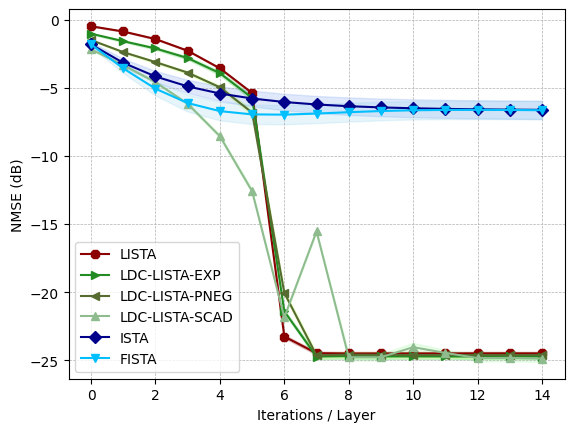

In [46]:
plt.plot(np.mean(LISTA_LOSS, axis = 0), label='LISTA', color='darkred', marker = '8')
plt.fill_between(range(LAYERS), 
                    np.mean(LISTA_LOSS, axis = 0) - (2/np.sqrt(LISTA_LOSS.shape[1])) * np.std(LISTA_LOSS, axis = 0), 
                    np.mean(LISTA_LOSS, axis = 0) + (2/np.sqrt(LISTA_LOSS.shape[1])) * np.std(LISTA_LOSS, axis = 0), 
                    color='darkred', 
                    alpha=0.2)

plt.plot(np.mean(LDC_LISTA_EXP_LOSS, axis = 0), label='LDC-LISTA-EXP', color='forestgreen', marker = '>')
plt.fill_between(range(LAYERS), 
                    np.mean(LDC_LISTA_EXP_LOSS, axis = 0) - (2/np.sqrt(LDC_LISTA_EXP_LOSS.shape[1])) * np.std(LDC_LISTA_EXP_LOSS, axis = 0), 
                    np.mean(LDC_LISTA_EXP_LOSS, axis = 0) + (2/np.sqrt(LDC_LISTA_EXP_LOSS.shape[1])) * np.std(LDC_LISTA_EXP_LOSS, axis = 0), 
                    color='limegreen', 
                    alpha=0.2)

plt.plot(np.mean(LDC_LISTA_PNEG_LOSS, axis = 0), label='LDC-LISTA-PNEG', color='darkolivegreen', marker = '<')
plt.fill_between(range(LAYERS), 
                    np.mean(LDC_LISTA_PNEG_LOSS, axis = 0) - (2/np.sqrt(LDC_LISTA_PNEG_LOSS.shape[1])) * np.std(LDC_LISTA_PNEG_LOSS, axis = 0), 
                    np.mean(LDC_LISTA_PNEG_LOSS, axis = 0) + (2/np.sqrt(LDC_LISTA_PNEG_LOSS.shape[1])) * np.std(LDC_LISTA_PNEG_LOSS, axis = 0), 
                    color='greenyellow', 
                    alpha=0.2)

plt.plot(np.mean(LDC_LISTA_SCAD_LOSS, axis = 0), label='LDC-LISTA-SCAD', color='darkseagreen', marker = '^')
plt.fill_between(range(LAYERS), 
                    np.mean(LDC_LISTA_SCAD_LOSS, axis = 0) - (2/np.sqrt(LDC_LISTA_SCAD_LOSS.shape[1])) * np.std(LDC_LISTA_SCAD_LOSS, axis = 0), 
                    np.mean(LDC_LISTA_SCAD_LOSS, axis = 0) + (2/np.sqrt(LDC_LISTA_SCAD_LOSS.shape[1])) * np.std(LDC_LISTA_SCAD_LOSS, axis = 0), 
                    color='palegreen', 
                    alpha=0.2)

plt.plot(np.mean(ISTA_LOSS, axis = 0), label='ISTA', color='darkblue', marker = 'D')
plt.fill_between(range(LAYERS), 
                np.mean(ISTA_LOSS, axis = 0) - (2/np.sqrt(ISTA_LOSS.shape[1])) * np.std(ISTA_LOSS, axis = 0), 
                np.mean(ISTA_LOSS, axis = 0) + (2/np.sqrt(ISTA_LOSS.shape[1])) * np.std(ISTA_LOSS, axis = 0), 
                color='cornflowerblue', 
                alpha=0.2)

plt.plot(np.mean(FISTA_LOSS, axis = 0), label='FISTA', color='deepskyblue', marker = 'v')
plt.fill_between(range(LAYERS), 
                np.mean(FISTA_LOSS, axis = 0) - (2/np.sqrt(FISTA_LOSS.shape[1])) * np.std(FISTA_LOSS, axis = 0), 
                np.mean(FISTA_LOSS, axis = 0) + (2/np.sqrt(FISTA_LOSS.shape[1])) * np.std(FISTA_LOSS, axis = 0), 
                color='skyblue', 
                alpha=0.2)

plt.xticks(range(LAYERS))

plt.ylabel('NMSE (dB)')
plt.xlabel('Iterations / Layer')

plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))

plt.grid(True, which="both", ls="--", linewidth=0.5)
plt.legend()

In [47]:
M = 10
LAYERS = 20
BETA_INIT = 0.4
EPOCHS = 50
SNR = 1000

LISTA_LOSS = torch.zeros((M, LAYERS))
LDC_LISTA_EXP_LOSS = torch.zeros((M, LAYERS))
LDC_LISTA_PNEG_LOSS = torch.zeros((M, LAYERS))
LDC_LISTA_SCAD_LOSS = torch.zeros((M, LAYERS))

ISTA_LOSS = torch.zeros((M, LAYERS))
FISTA_LOSS = torch.zeros((M, LAYERS))

for m in tqdm(range(M)):
    # Dimensions for the signal, its sparsity and its observation

    n_ = 300
    m_ = 500
    p_ = 0.1

    # Sensing matrix

    A_ = torch.normal(0, torch.sqrt(torch.tensor(1/m_)), size = (m_, n_))
    A_ /= torch.linalg.norm(A_, dim = 0)

    # Building a training set and a test set 
    train_set = SyntheticSignals(
        A = A_,
        n = n_,        
        m = m_,
        p = p_,
        SNR = SNR,
        size = 4000
        ).set_loader()

    test_set = SyntheticSignals(
        A = A_,
        n = n_,        
        m = m_,
        p = p_,
        SNR = SNR,
        size = 1000
        ).set_loader()
    
    model1 = LISTA_Net(torch.clone(A_), BETA_INIT, LAYERS)
    train(model1, train_set, test_set, num_epochs = EPOCHS, verbose=False)

    model2 = LDC_ISTA(torch.clone(A_), 'EXP', BETA_INIT, T = LAYERS)
    train(model2, train_set, test_set, num_epochs = EPOCHS, verbose=False)

    model3 = LDC_ISTA(torch.clone(A_), 'PNEG', BETA_INIT, T = LAYERS)
    train(model3, train_set, test_set, num_epochs = EPOCHS, verbose=False)

    model4 = LDC_ISTA(torch.clone(A_), 'SCAD', BETA_INIT, T = LAYERS)
    train(model4, train_set, test_set, num_epochs = EPOCHS, verbose=False)

    LISTA_LOSS[m,:] = model1.compute_nmse_inference(test_set)
    LDC_LISTA_EXP_LOSS[m,:] = model2.compute_nmse_inference(test_set)
    LDC_LISTA_PNEG_LOSS[m,:] = model3.compute_nmse_inference(test_set)
    LDC_LISTA_SCAD_LOSS[m,:] = model4.compute_nmse_inference(test_set)

    ISTA_LOSS[m,:] = ISTA_BATCH(test_set, LAYERS, A_, rho = BETA_INIT)
    FISTA_LOSS[m,:] = FISTA_BATCH(test_set, LAYERS, A_, rho = BETA_INIT)

100%|██████████| 10/10 [26:16<00:00, 157.61s/it]


In [48]:
LISTA_LOSS = LISTA_LOSS.cpu().numpy()
LDC_LISTA_EXP_LOSS = LDC_LISTA_EXP_LOSS.cpu().numpy()
LDC_LISTA_PNEG_LOSS = LDC_LISTA_PNEG_LOSS.cpu().numpy()
LDC_LISTA_SCAD_LOSS = LDC_LISTA_SCAD_LOSS.cpu().numpy()

ISTA_LOSS = ISTA_LOSS.cpu().numpy()
FISTA_LOSS = FISTA_LOSS.cpu().numpy()

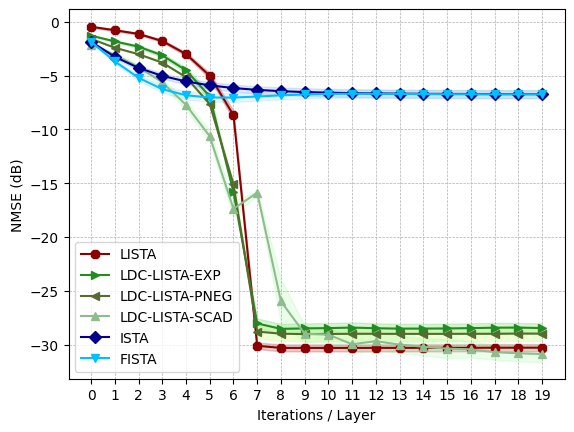

In [50]:
plt.plot(np.mean(LISTA_LOSS, axis = 0), label='LISTA', color='darkred', marker = '8')
plt.fill_between(range(LAYERS), 
                    np.mean(LISTA_LOSS, axis = 0) - (2/np.sqrt(LISTA_LOSS.shape[1])) * np.std(LISTA_LOSS, axis = 0), 
                    np.mean(LISTA_LOSS, axis = 0) + (2/np.sqrt(LISTA_LOSS.shape[1])) * np.std(LISTA_LOSS, axis = 0), 
                    color='darkred', 
                    alpha=0.2)

plt.plot(np.mean(LDC_LISTA_EXP_LOSS, axis = 0), label='LDC-LISTA-EXP', color='forestgreen', marker = '>')
plt.fill_between(range(LAYERS), 
                    np.mean(LDC_LISTA_EXP_LOSS, axis = 0) - (2/np.sqrt(LDC_LISTA_EXP_LOSS.shape[1])) * np.std(LDC_LISTA_EXP_LOSS, axis = 0), 
                    np.mean(LDC_LISTA_EXP_LOSS, axis = 0) + (2/np.sqrt(LDC_LISTA_EXP_LOSS.shape[1])) * np.std(LDC_LISTA_EXP_LOSS, axis = 0), 
                    color='limegreen', 
                    alpha=0.2)

plt.plot(np.mean(LDC_LISTA_PNEG_LOSS, axis = 0), label='LDC-LISTA-PNEG', color='darkolivegreen', marker = '<')
plt.fill_between(range(LAYERS), 
                    np.mean(LDC_LISTA_PNEG_LOSS, axis = 0) - (2/np.sqrt(LDC_LISTA_PNEG_LOSS.shape[1])) * np.std(LDC_LISTA_PNEG_LOSS, axis = 0), 
                    np.mean(LDC_LISTA_PNEG_LOSS, axis = 0) + (2/np.sqrt(LDC_LISTA_PNEG_LOSS.shape[1])) * np.std(LDC_LISTA_PNEG_LOSS, axis = 0), 
                    color='greenyellow', 
                    alpha=0.2)

plt.plot(np.mean(LDC_LISTA_SCAD_LOSS, axis = 0), label='LDC-LISTA-SCAD', color='darkseagreen', marker = '^')
plt.fill_between(range(LAYERS), 
                    np.mean(LDC_LISTA_SCAD_LOSS, axis = 0) - (2/np.sqrt(LDC_LISTA_SCAD_LOSS.shape[1])) * np.std(LDC_LISTA_SCAD_LOSS, axis = 0), 
                    np.mean(LDC_LISTA_SCAD_LOSS, axis = 0) + (2/np.sqrt(LDC_LISTA_SCAD_LOSS.shape[1])) * np.std(LDC_LISTA_SCAD_LOSS, axis = 0), 
                    color='palegreen', 
                    alpha=0.2)

plt.plot(np.mean(ISTA_LOSS, axis = 0), label='ISTA', color='darkblue', marker = 'D')
plt.fill_between(range(LAYERS), 
                np.mean(ISTA_LOSS, axis = 0) - (2/np.sqrt(ISTA_LOSS.shape[1])) * np.std(ISTA_LOSS, axis = 0), 
                np.mean(ISTA_LOSS, axis = 0) + (2/np.sqrt(ISTA_LOSS.shape[1])) * np.std(ISTA_LOSS, axis = 0), 
                color='cornflowerblue', 
                alpha=0.2)

plt.plot(np.mean(FISTA_LOSS, axis = 0), label='FISTA', color='deepskyblue', marker = 'v')
plt.fill_between(range(LAYERS), 
                np.mean(FISTA_LOSS, axis = 0) - (2/np.sqrt(FISTA_LOSS.shape[1])) * np.std(FISTA_LOSS, axis = 0), 
                np.mean(FISTA_LOSS, axis = 0) + (2/np.sqrt(FISTA_LOSS.shape[1])) * np.std(FISTA_LOSS, axis = 0), 
                color='skyblue', 
                alpha=0.2)

plt.xticks(range(LAYERS))

plt.ylabel('NMSE (dB)')
plt.xlabel('Iterations / Layer')

#plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))

plt.grid(True, which="both", ls="--", linewidth=0.5)
plt.legend()

In [ ]:
exp_3 = {
    'LISTA':LISTA_LOSS,
    'LDC-LISTA-EXP':LDC_LISTA_EXP_LOSS,
    'LDC-LISTA-PNEG':LDC_LISTA_PNEG_LOSS,
    'LDC-LISTA-SCAD':LDC_LISTA_SCAD_LOSS,
    'ISTA':ISTA_LOSS,
    'FISTA':FISTA_LOSS
}

with open('test_loss_experiment_3.pkl', 'wb') as handle:
    pickle.dump(test_losses, handle, protocol=pickle.HIGHEST_PROTOCOL)
